<a href="https://colab.research.google.com/github/sayakpaul/MIRNet-TFLite/blob/main/MIRNet_TFLite_Fixed_Shape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the TensorFlow Lite model conversion and inference processes for the **MIRNet** model as proposed by [Learning Enriched Features for Real Image Restoration and Enhancement](https://arxiv.org/pdf/2003.06792v2.pdf). This model is capable of enhancing low-light images upto a great extent. 

<p align="center">
<img src="https://github.com/soumik12345/MIRNet/raw/master/assets/lol_results.gif"</img><br>
<small><a href="https://github.com/soumik12345/MIRNet/blob/master/assets/lol_results.gif">Source</a></small>
</p>

Model training code and pre-trained weights are provided by **Soumik** through [this repository](https://github.com/soumik12345/MIRNet/). 

## Initial setup

In [1]:
!git clone https://github.com/soumik12345/MIRNet
%cd MIRNet

/content/MIRNet


In [2]:
!pip install -q wandb

     |████████████████████████████████| 1.8MB 9.4MB/s 
     |████████████████████████████████| 163kB 31.1MB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 133kB 16.0MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 


In [2]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from mirnet.inference import Inferer
from mirnet.utils import download_dataset, plot_result

import tensorflow as tf
import numpy as np
print(tf.__version__)

2.3.0


## Download dataset and pre-trained weights

In [4]:
download_dataset('LOL')

Downloading...
From: https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
To: /content/MIRNet/LOLdataset.zip
347MB [00:01, 242MB/s]


Unpacking Dataset
Done!!!


In [3]:
inferer = Inferer()
inferer.download_weights('1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='low_light_weights_best.h5'
)
inferer.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, None, 6 36928       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [6]:
# Save model in SavedModel format
inferer.model.save('mirnet')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mirnet/assets


## TensorFlow Lite model conversion

As per [this notebook](https://github.com/soumik12345/MIRNet/blob/master/notebooks/MIRNet_Low_Light_Train.ipynb), `our485/low/` should contain the training images that we can use to build our representative dataset generator. 

In [8]:
SAMPLE_IMGS = glob('./our485/low/*')[:5]
IMG_SIZE = 400

def representative_dataset_gen():
    for image_path in SAMPLE_IMGS:
        original_image = Image.open(image_path)
        width, height = original_image.size
        preprocessed_image = original_image.resize(
            (
                IMG_SIZE,
                IMG_SIZE
            ),
            Image.ANTIALIAS)
        preprocessed_image = tf.keras.preprocessing.image.img_to_array(preprocessed_image)
        preprocessed_image = preprocessed_image.astype('float32') / 255.0
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        yield [preprocessed_image]

In [16]:
def convert_tflite(saved_model='mirnet', quant='dr', filename='mirnet_dr.tflite'):
    model = tf.saved_model.load(saved_model)
    concrete_func = model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    concrete_func.inputs[0].set_shape([1, IMG_SIZE, IMG_SIZE, 3]) 
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

    if quant=='dr':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    elif quant=='fp16':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
    elif quant=='int8':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset_gen
        # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        # converter.inference_input_type = tf.uint8
        # converter.inference_output_type = tf.uint8
    
    tflite_model = converter.convert()
    open(filename, 'wb').write(tflite_model)
    print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

If you want the TensorFlow Lite model to handle dynamic shapes refer to [this notebook](https://colab.research.google.com/github/sayakpaul/MIRNet-TFLite/blob/main/MIRNet_TFLite.ipynb). 

In [10]:
convert_tflite(saved_model='mirnet', quant='dr', filename='mirnet_dr.tflite')

Model size is 35.511017 MBs.


In [11]:
convert_tflite(saved_model='mirnet', quant='fp16', filename='mirnet_fp16.tflite')

Model size is 70.084686 MBs.


In [17]:
convert_tflite(saved_model='mirnet', quant='int8', filename='mirnet_int8.tflite')

Model size is 37.361176 MBs.


In [18]:
!ls -lh *.h5
!ls -lh *.tflite

-rw-r--r-- 1 root root 141M Dec  5 05:23 low_light_weights_best.h5
-rw-r--r-- 1 root root 36M Dec  5 05:30 mirnet_dr.tflite
-rw-r--r-- 1 root root 71M Dec  5 05:31 mirnet_fp16.tflite
-rw-r--r-- 1 root root 38M Dec  5 06:06 mirnet_int8.tflite


The TensorFlow Lite model (`mirnet_dr.tflite`), because of its lower size, can be deployed to a mobile application. 

## TensorFlow Lite inference utilities

In [4]:
LOW_LIGHT_IMGS = glob('./eval15/low/*')

MODEL_DICT = {
    "dr": "mirnet_dr.tflite",
    "fp16": "mirnet_fp16.tflite",
    "int8": "mirnet_int8.tflite"
}

In [5]:
def preprocess_image(image_path):
    original_image = Image.open(image_path)
    width, height = original_image.size
    preprocessed_image = original_image.resize(
        (
            IMG_SIZE,
            IMG_SIZE
        ),
        Image.ANTIALIAS)
    preprocessed_image = tf.keras.preprocessing.image.img_to_array(preprocessed_image)
    preprocessed_image = preprocessed_image.astype('float32') / 255.0
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    
    return original_image, preprocessed_image

In [6]:
def infer_tflite(model_type, image):
    interpreter = tf.lite.Interpreter(model_path=MODEL_DICT[model_type])
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()
    raw_prediction = interpreter.tensor(output_index)
    output_image = raw_prediction()

    output_image = output_image.squeeze() * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    return output_image

Some parts of the above two functions have been referred from [here](https://github.com/soumik12345/MIRNet/blob/master/mirnet/inference.py). 

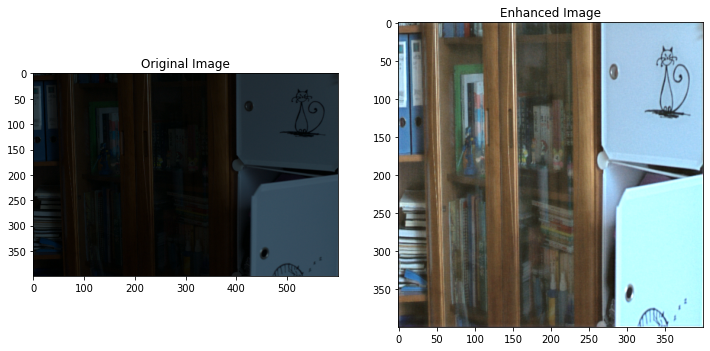

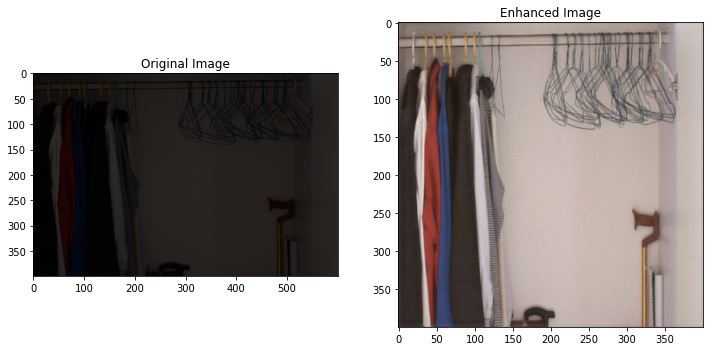

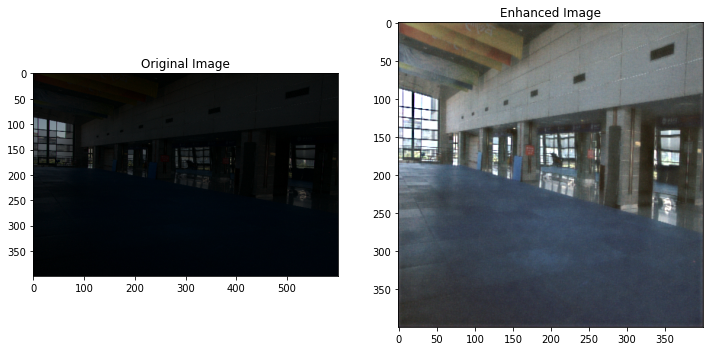

In [ ]:
# @title Run inference
model_type = "dr" #@param ["dr", "fp16", "int8"]

for image_path in LOW_LIGHT_IMGS[:5]:
    original_image, preprocessed_image = preprocess_image(image_path)
    output_image = infer_tflite(model_type, preprocessed_image)
    plot_result(Image.fromarray(np.uint8(original_image)), output_image)

**Note** that the integer quantized model takes a very long time to produce results. 

## Compare results with the original model

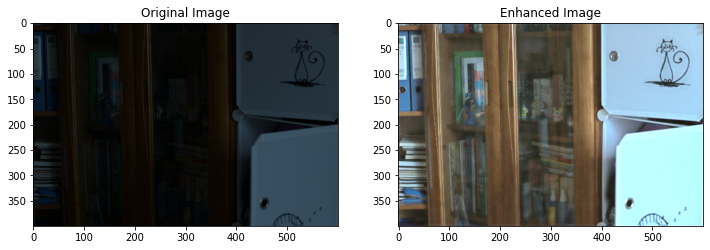

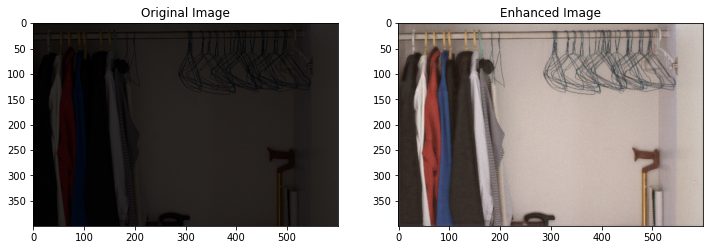

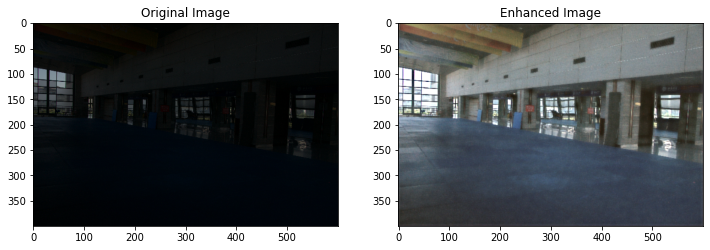

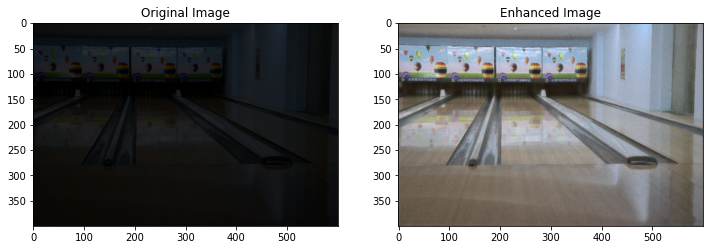

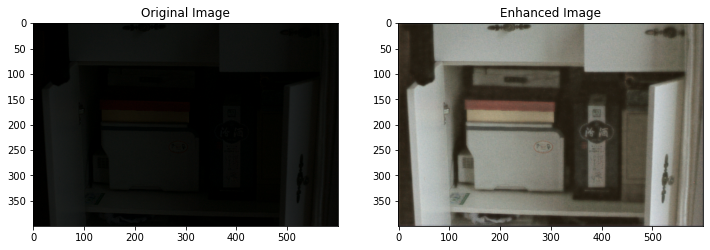

In [ ]:
for image_path in LOW_LIGHT_IMGS[:5]:
    original_image, output_image = inferer.infer(image_path)
    plot_result(original_image, output_image)